In [1]:
import numpy as np
import glob
import datetime
import math
import random
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib2tikz
import pretty_midi
from pypianoroll import Multitrack, Track
import librosa.display
from utils import *
import write_midi

midi_type = "temp"
ROOT_PATH = 'D:/Anaconda/Jupyter Notebook/pretty_midi/dataset/MIDI'
test_ratio = 0.1
LAST_BAR_MODE = 'remove'

In [4]:
def get_bar_piano_roll(piano_roll):
    if int(piano_roll.shape[0] % 64) is not 0:
        if LAST_BAR_MODE == 'fill':
            piano_roll = np.concatenate((piano_roll, np.zeros((64 - piano_roll.shape[0] % 64, 128))), axis=0)
        elif LAST_BAR_MODE == 'remove':
            piano_roll = np.delete(piano_roll,  np.s_[-int(piano_roll.shape[0] % 64):], axis=0)
    piano_roll = piano_roll.reshape(-1, 64, 128)
    return piano_roll

In [3]:
"""4. merge and crop"""
"""merge different tracks and crop the data to (#, 64, 84, 1)"""
# train_test = 'origin_ABBA_full_pop2classic'
# song_list = ['ABBA', 'Billie_Jean', 'ClaireDeLune', 'Flirtation', 'Gladiators', 'Grande_Walz', 'Just_Dance', 'Perfect_new']
song_list = ['ABBA']
for song in song_list:
#     song='ClaireDeLune'
    if not os.path.exists(os.path.join(ROOT_PATH, '{}/{}_data'.format(midi_type, song))):
        os.makedirs(os.path.join(ROOT_PATH, '{}/{}_data'.format(midi_type, song)))

    l = [f for f in os.listdir(os.path.join(ROOT_PATH, '{}/{}'.format(midi_type, song)))]
    # print(l)
    count = 0
    for i in range(len(l)):
        try:
            multitrack = Multitrack(beat_resolution=4, name=os.path.splitext(l[i])[0])
            x = pretty_midi.PrettyMIDI(os.path.join(ROOT_PATH, '{}/{}'.format(midi_type, song), l[i]))
            multitrack.parse_pretty_midi(x)

            category_list = {'Piano': [], 'Drums': []}
            program_dict = {'Piano': 0, 'Drums': 0}

            for idx, track in enumerate(multitrack.tracks):
                if track.is_drum:
                    category_list['Drums'].append(idx)
                else:
                    category_list['Piano'].append(idx)
            tracks = []
            merged = multitrack[category_list['Piano']].get_merged_pianoroll()
    #         merged = multitrack[category_list['Piano']].get_merged_pianoroll(mode='max')
            if song == 'ABBA':
                print(song, ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
                merged = np.delete(merged, range(131), axis=0)
            print(merged.shape)

            pr = get_bar_piano_roll(merged)
            print(pr.shape)
            pr_clip = pr[:, :, 24:108]
            print(pr_clip.shape)
            
    #         if int(pr_clip.shape[0] % 4) != 0:
    #             pr_clip = np.delete(pr_clip, np.s_[-int(pr_clip.shape[0] % 4):], axis=0)
            if song == 'Just_Dance':
                print(song, ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
                pr_clip = np.delete(pr_clip, [0, 1], axis=0)
            elif song == 'Billie_Jean':
                print(song, ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
                pr_clip = np.delete(pr_clip, [0, 1, 2], axis=0)
            pr_re = pr_clip.reshape(-1, 64, 84, 1)
            print(pr_re.shape)
    #         if pr_re.shape[0] == 0:
    #             continue
    #         save_midis(pr_re, os.path.join(ROOT_PATH, 'MIDI/pop/pop_test/cleaner_midi_gen', os.path.splitext(l[i])[0] +
    #                                        '.mid'))
    #         np.save(os.path.join(ROOT_PATH, '{}/{}'.format(midi_type, train_test), os.path.splitext(l[i])[0] + '.npy'), pr_re>0)
    #         np.save(os.path.join(ROOT_PATH, '{}/{}_data/{}.npy'.format(midi_type, song, l[i])), pr_re>0)
            np.save(os.path.join(ROOT_PATH, '{}/{}_data'.format(midi_type, song), os.path.splitext(l[i])[0] + '.npy'), pr_re>0)
        except:
            count += 1
            print('Wrong', l[i])
            continue
    print(count)

ABBA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(1405, 128)
(21, 64, 128)
(21, 64, 84)
(21, 64, 84, 1)
ABBA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(1405, 128)
(21, 64, 128)
(21, 64, 84)
(21, 64, 84, 1)
ABBA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(1405, 128)
(21, 64, 128)
(21, 64, 84)
(21, 64, 84, 1)
ABBA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(1405, 128)
(21, 64, 128)
(21, 64, 84)
(21, 64, 84, 1)
ABBA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(1405, 128)
(21, 64, 128)
(21, 64, 84)
(21, 64, 84, 1)
0


In [4]:
"""6. separate numpy array file into single phrases"""
# train_test = 'train'
# song='Perfect_new'
# song_list = ['ABBA', 'Billie_Jean', 'ClaireDeLune', 'Flirtation', 'Gladiators', 'Grande_Walz', 'Just_Dance', 'Perfect_new']
song_list = ['ABBA']
for song in song_list:
    l = [f for f in os.listdir(os.path.join(ROOT_PATH, '{}/{}_data'.format(midi_type, song)))]
    for j in range(len(l)):
        directory = os.path.splitext(l[j])[0]
        print(directory)
        if not os.path.exists(os.path.join(ROOT_PATH, '{}/{}_data/{}'.format(midi_type, song, directory))):
            os.makedirs(os.path.join(ROOT_PATH, '{}/{}_data/{}'.format(midi_type, song, directory)))
        x = np.load(os.path.join(ROOT_PATH, '{}/{}_data'.format(midi_type, song), l[j]))
        print(x.shape)
        count = 0
        for i in range(4):
            # filter too sparse files
            if x[i].nonzero()[0].shape[0] > 1:
                print(x[i].shape, x[i].nonzero()[0].shape[0], np.max(x[i]))
                count += 1
                data = x[i].reshape(64, 84, 1)
                print(data.shape)
                np.save(os.path.join(ROOT_PATH, '{}/{}_data/{}/{}_{}.npy'.format(midi_type, song, directory, directory, count)), data)
    #         print(x[i].shape)
       # if count == 11216:
       #     break
        print(count)

ABBA
(21, 64, 84, 1)
(64, 84, 1) 332 True
(64, 84, 1)
(64, 84, 1) 380 True
(64, 84, 1)
(64, 84, 1) 354 True
(64, 84, 1)
(64, 84, 1) 212 True
(64, 84, 1)
4
attention_ABBA_full_pop2classic
(21, 64, 84, 1)
(64, 84, 1) 211 True
(64, 84, 1)
(64, 84, 1) 281 True
(64, 84, 1)
(64, 84, 1) 260 True
(64, 84, 1)
(64, 84, 1) 217 True
(64, 84, 1)
4
both_ABBA_full_pop2classic
(21, 64, 84, 1)
(64, 84, 1) 165 True
(64, 84, 1)
(64, 84, 1) 191 True
(64, 84, 1)
(64, 84, 1) 223 True
(64, 84, 1)
(64, 84, 1) 134 True
(64, 84, 1)
4
origin_ABBA_full_pop2classic
(21, 64, 84, 1)
(64, 84, 1) 226 True
(64, 84, 1)
(64, 84, 1) 291 True
(64, 84, 1)
(64, 84, 1) 270 True
(64, 84, 1)
(64, 84, 1) 145 True
(64, 84, 1)
4
sn_ABBA_full_pop2classic
(21, 64, 84, 1)
(64, 84, 1) 226 True
(64, 84, 1)
(64, 84, 1) 297 True
(64, 84, 1)
(64, 84, 1) 306 True
(64, 84, 1)
(64, 84, 1) 152 True
(64, 84, 1)
4


In [50]:
models=['origin', 'sn', 'attention', 'both']
# directions=['classic2jazz', 'classic2pop', 'pop2classic', 'jazz2classic']
# song_list = ['ABBA', 'billiejean', 'ClaireDeLune', 'Flirtation', 'Gladiators', 'Grande_Waltz', 'justdance', 'perfect_new']
directions=['classic2pop', 'pop2classic']
song_list = ['ABBA', 'billiejean', 'Flirtation', 'Gladiators', 'Grande_Waltz', 'justdance', 'perfect_new']
model = models[3]
song = song_list[4]
direction = directions[0]
name_transfer = '{}_{}_full_{}'.format(model, song, direction)
name_origin = '{}'.format(song)
content_retention = []
idx_list = []
for i in range(4):
    path_transfer = os.path.join(ROOT_PATH, '{}/{}_data/{}/{}_{}.npy'.format(midi_type, song, name_transfer, name_transfer, i+1))
    path_origin = os.path.join(ROOT_PATH, '{}/{}_data/{}/{}_{}.npy'.format(midi_type, song, name_origin, name_origin, i+1))
#     print(path_transfer)
#     print(path_origin)
    origin_npy = np.load(path_origin) * 1.
    transfer_npy = np.load(path_transfer) * 1.
   
    source_matrix = np.squeeze(origin_npy*1.0)
    transfer_origin = np.squeeze(transfer_npy*1.0)
    
    idx = 0
    retention_min = np.array([[100, 100, 100]])
    
    
    for j in range(84):
    # calculate content retention
        transfer_matrix = np.roll(transfer_origin, j, axis=1)
        temp_matrix = transfer_matrix - source_matrix
        added_matrix = np.where(temp_matrix > 0)[0].shape[0]
        removed_matrix = np.where(temp_matrix < 0)[0].shape[0]
        notes = np.nonzero(source_matrix)[0].shape[0]

        retention_temp = np.zeros((1,3))
        retention_temp[0, 0] = added_matrix / notes
        retention_temp[0, 1] = removed_matrix / notes
        retention_temp[0, 2] = retention_temp[0, 0] + retention_temp[0, 1]
#         print(retention_temp[0, 2], retention_min[0, 2])
        if retention_temp[0, 2] < retention_min[0, 2]:
            retention_min = retention_temp.copy()
            idx = j
    
#     retention = np.zeros((1,3))
#     retention[0, 0] = added_matrix / notes
#     retention[0, 1] = removed_matrix / notes
#     retention[0, 2] = retention[0, 0] + retention[0, 1]
#     print(idx)
    content_retention.append(retention_min.copy())
    idx_list.append(idx)

# print(content_retention)    
content_retention = np.array(content_retention).astype(np.float32)
retention_mean = np.mean(content_retention, axis = 0)
retention_variance = np.var(content_retention, axis = 0)
print(name_transfer, ": mean of content retention maxtrix: (added, removed, total) =", retention_mean)
print(name_transfer, ": variance of content retention maxtrix: (added, removed, total) =", retention_variance)
print(idx_list)

both_Grande_Waltz_full_classic2pop : mean of content retention maxtrix: (added, removed, total) = [[2.0454412 0.6669865 2.7124276]]
both_Grande_Waltz_full_classic2pop : variance of content retention maxtrix: (added, removed, total) = [[2.9687033  0.03249271 2.4131136 ]]
[2, 4, 4, 2]


<function matplotlib.pyplot.show(*args, **kw)>

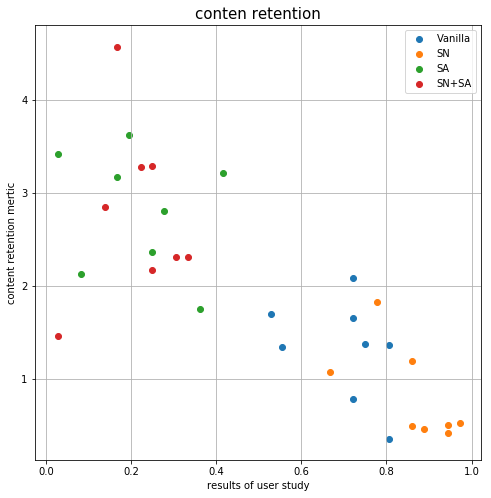

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='auto')


x1 = np.array([0.805555556, 0.527777778, 0.75, 0.722222222, 0.722222222, 0.722222222, 0.805555556, 0.555555556])
x2 = np.array([0.333333333, 0.222222222, 0.166666667, 0.25, 0.305555556, 0.027777778, 0.138888889, 0.25])
x3 = np.array([0.777777778, 0.972222222, 0.666666667, 0.861111111, 0.944444444, 0.888888889, 0.861111111, 0.944444444])
x4 = np.array([0.083333333, 0.277777778, 0.416666667, 0.166666667, 0.027777778, 0.361111111, 0.194444444, 0.25])


y1 = np.array([0.3465, 1.6936, 1.3685, 1.6475, 2.0778, 0.7782, 1.3603, 1.3442])
y2 = np.array([2.3108, 3.2787, 4.5677, 3.2823, 2.3047, 1.4544, 2.8492, 2.1698])
y3 = np.array([1.8226, 0.5232, 1.0730, 1.1940, 0.4162, 0.4543, 0.4923, 0.4973])
y4 = np.array([2.1311, 2.8063, 3.2087, 3.1738, 3.4189, 1.7485, 3.6216, 2.3586])



plt.scatter(x1, y1, label='Vanilla')
plt.scatter(x3, y3, label='SN')
plt.scatter(x4, y4, label='SA')
plt.scatter(x2, y2, label='SN+SA')
plt.grid(True)
plt.xlabel('results of user study')
plt.ylabel('content retention mertic')
plt.title('conten retention', fontsize=15)
plt.legend(loc="upper right")
matplotlib2tikz.save("content_retention.tex")
# plt.savefig('content_retention.jpg')
plt.show

In [4]:
x = np.array([[0.805555556, 0.527777778, 0.75, 0.722222222, 0.722222222, 0.722222222, 0.805555556, 0.555555556,
              0.333333333, 0.222222222, 0.166666667, 0.25, 0.305555556, 0.027777778, 0.138888889, 0.25,
              0.777777778, 0.972222222, 0.666666667, 0.861111111, 0.944444444, 0.888888889, 0.861111111, 0.944444444,              
              0.083333333, 0.277777778, 0.416666667, 0.166666667, 0.027777778, 0.361111111, 0.194444444, 0.25],
             [0.3465, 1.6936, 1.3685, 1.6475, 2.0778, 0.7782, 1.3603, 1.3442,
              2.3108, 3.2787, 4.5677, 3.2823, 2.3047, 1.4544, 2.8492, 2.1698,
              1.8226, 0.5232, 1.0730, 1.1940, 0.4162, 0.4543, 0.4923, 0.4973,             
              2.1311, 2.8063, 3.2087, 3.1738, 3.4189, 1.7485, 3.6216, 2.3586]])


print(np.corrcoef(x))

[[ 1.         -0.80541761]
 [-0.80541761  1.        ]]


<function matplotlib.pyplot.show(*args, **kw)>

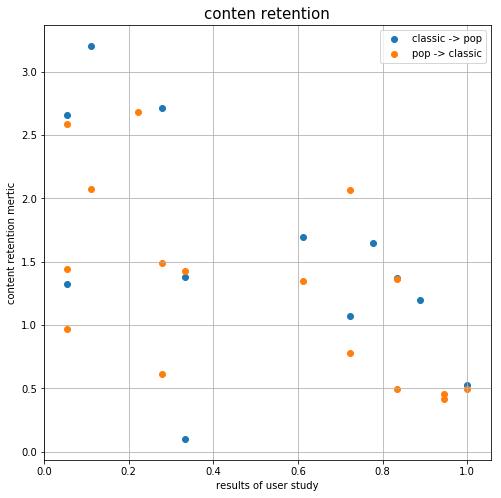

In [2]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='auto')

x1 = np.array([0.611111111, 0.055555556, 1, 0.333333333,
              0.833333333, 0.111111111, 0.722222222, 0.333333333,
              0.777777778, 0.277777778, 0.888888889, 0.055555556])
y1 = np.array([1.6936, 2.6579, 0.5232, 1.3795,
              1.3685, 3.2053, 1.0730, 0.0980,
              1.6475, 2.7124, 1.1940, 1.3250])
x2 = np.array([0.722222222, 0.277777778, 0.944444444, 0.055555556,
              0.722222222, 0.055555556, 0.944444444, 0.277777778,
              0.833333333, 0.111111111, 0.833333333, 0.222222222,
              0.611111111, 0.055555556, 1, 0.333333333])
y2 = np.array([2.0636, 1.4926, 0.4162, 2.5896,
              0.7782, 0.9639, 0.4543, 0.6139,
              1.3603, 2.0747, 0.4923, 2.6797,
              1.3442, 1.4391, 0.4973, 1.4229])



plt.scatter(x1, y1, label='classic -> pop')
plt.scatter(x2, y2, label='pop -> classic')
plt.grid(True)
plt.xlabel('results of user study')
plt.ylabel('content retention mertic')
plt.title('conten retention', fontsize=15)
plt.legend(loc="upper right")
matplotlib2tikz.save("content_retention_new.tex")
# plt.savefig('content_retention_new.jpg')
plt.show

In [54]:
x = np.array([[0.611111111, 0.055555556, 1, 0.333333333,
              0.833333333, 0.111111111, 0.722222222, 0.333333333,
              0.777777778, 0.277777778, 0.888888889, 0.055555556,              
              0.722222222, 0.277777778, 0.944444444, 0.055555556,
              0.722222222, 0.055555556, 0.944444444, 0.277777778,
              0.833333333, 0.111111111, 0.833333333, 0.222222222,
              0.611111111, 0.055555556, 1, 0.333333333],
             [1.6936, 2.6579, 0.5232, 1.3795,
              1.3685, 3.2053, 1.0730, 0.0980,
              1.6475, 2.7124, 1.1940, 1.3250,             
              2.0636, 1.4926, 0.4162, 2.5896,
              0.7782, 0.9639, 0.4543, 0.6139,
              1.3603, 2.0747, 0.4923, 2.6797,
              1.3442, 1.4391, 0.4973, 1.4229]])
print(np.corrcoef(x))

[[ 1.         -0.55651739]
 [-0.55651739  1.        ]]
